Model Accuracy: 0.9933333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       268
           1       1.00      0.94      0.97        32

    accuracy                           0.99       300
   macro avg       1.00      0.97      0.98       300
weighted avg       0.99      0.99      0.99       300


Feature Importance Scores:
            Feature  Importance
3   bandwidth_usage    0.121177
2  packet_loss_rate    0.108789
0    device_density    0.106033
1       time_of_day    0.002851

Classification Metrics Table:
              precision    recall  f1-score     support
0              0.992593  1.000000  0.996283  268.000000
1              1.000000  0.937500  0.967742   32.000000
accuracy       0.993333  0.993333  0.993333    0.993333
macro avg      0.996296  0.968750  0.982012  300.000000
weighted avg   0.993383  0.993333  0.993238  300.000000

Example Prediction:
Features: {'device_density': 888.0, 't

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


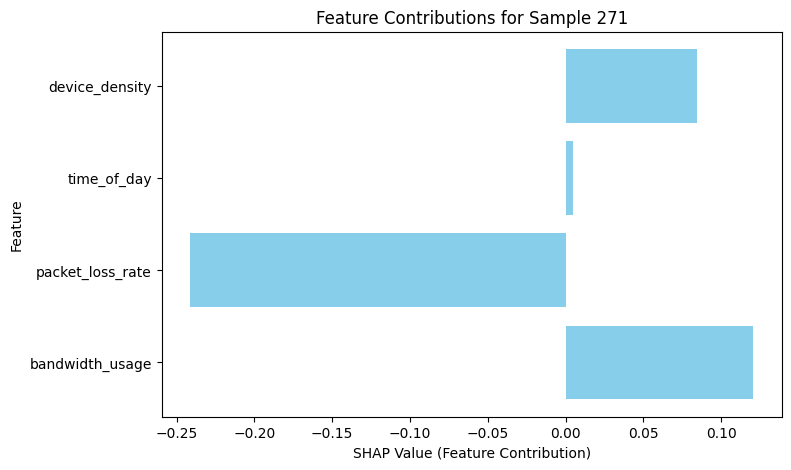

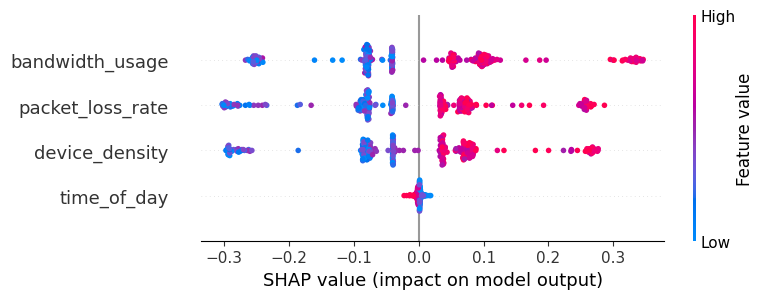


Visualizing Congested vs Non-Congested Scenarios...


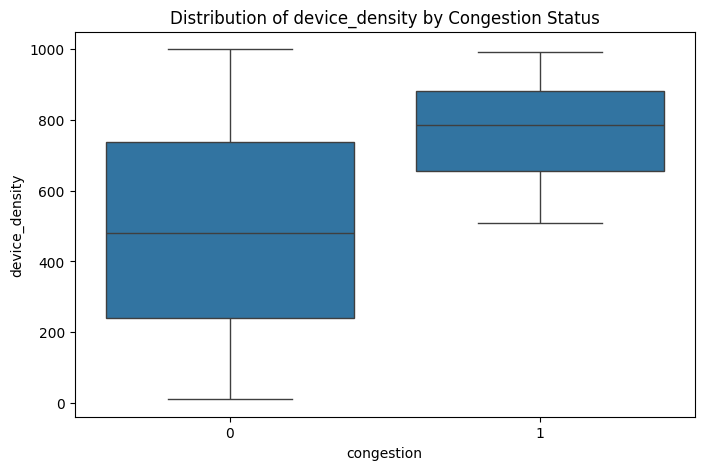

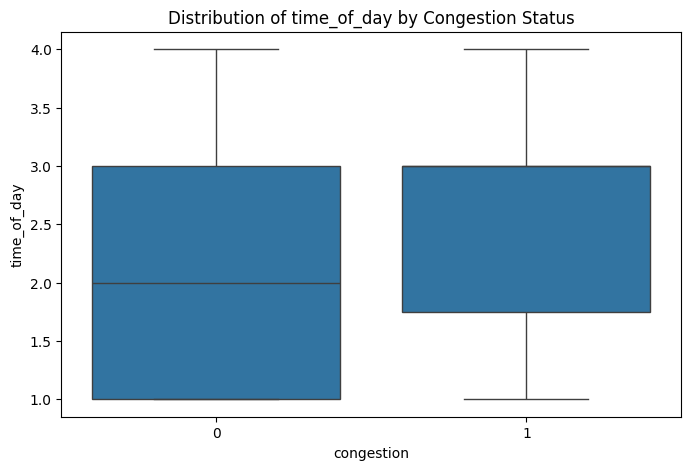

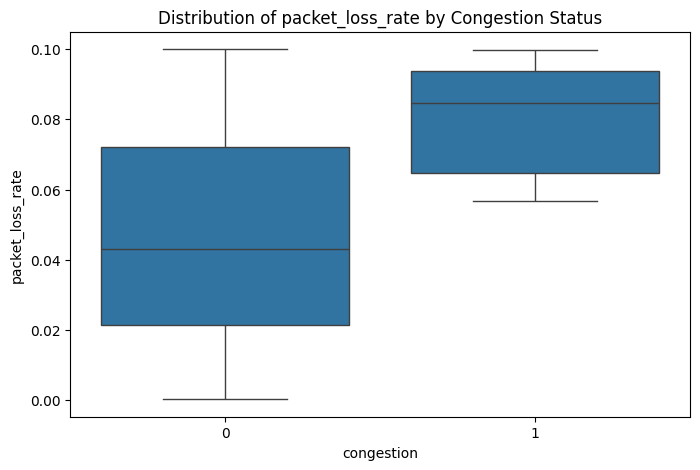

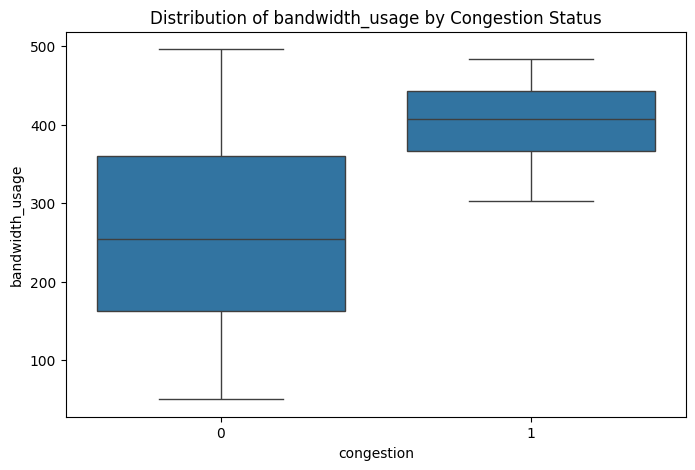

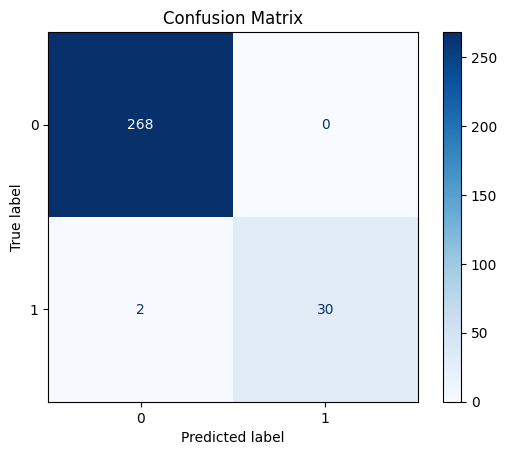

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import shap
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file_path='network_traffic_data.csv'):
    data = pd.read_csv(file_path)
    return data

def train_model(data):
    # Split features and target
    X = data[['device_density', 'time_of_day', 'packet_loss_rate', 'bandwidth_usage']]
    y = data['congestion']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train Random Forest model
    model = RandomForestClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print("Model Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return model, X_train, X_test, y_train, y_test, y_pred

def feature_importance(model, X_test, shap_values):
    # Check if SHAP values have 3 dimensions (samples x features x classes)
    if len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]  # Use SHAP values for the positive class

    # Ensure SHAP values are now 2D (samples x features)
    assert len(shap_values.shape) == 2, f"Expected 2D SHAP values, got {shap_values.shape}"

    # Compute mean absolute SHAP values for each feature
    importance_values = np.mean(np.abs(shap_values), axis=0)

    # Ensure importance_values is 1D
    assert len(importance_values.shape) == 1, f"Expected 1D importance values, got {importance_values.shape}"

    # Create DataFrame for feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': importance_values
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importance Scores:")
    print(feature_importance)
    return feature_importance

def classification_metrics_table(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("\nClassification Metrics Table:")
    print(report_df)
    return report_df

def example_predictions(model, X_test, shap_values):
    # Check if SHAP values have been sliced correctly
    if len(shap_values.shape) == 3:  # If SHAP values are still 3D, slice them for positive class
        shap_values = shap_values[:, :, 1]

    # Select a random sample from X_test
    sample_index = np.random.randint(0, len(X_test))
    sample_features = X_test.iloc[sample_index]
    sample_prediction = model.predict([sample_features])[0]
    shap_values_sample = shap_values[sample_index]  # SHAP values for the selected sample

    print(f"\nExample Prediction:")
    print(f"Features: {sample_features.to_dict()}")
    print(f"Prediction: {'Congestion' if sample_prediction == 1 else 'No Congestion'}")
    print(f"Feature Contributions (SHAP Values): {shap_values_sample}")

    # Bar plot for feature contributions
    plt.figure(figsize=(8, 5))
    feature_names = X_test.columns
    plt.barh(feature_names, shap_values_sample, color='skyblue')
    plt.xlabel("SHAP Value (Feature Contribution)")
    plt.ylabel("Feature")
    plt.title(f"Feature Contributions for Sample {sample_index}")
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
    plt.show()

def visualize_congestion_distribution(X_test, y_test):
    # Add congestion labels to X_test
    X_test_with_labels = X_test.copy()
    X_test_with_labels['congestion'] = y_test.values

    print("\nVisualizing Congested vs Non-Congested Scenarios...")
    for feature in X_test.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='congestion', y=feature, data=X_test_with_labels)
        plt.title(f"Distribution of {feature} by Congestion Status")
        plt.show()

def plot_confusion_matrix(y_test, y_pred, model):
    # Generate and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

def shap_summary_plot(shap_values, X_test):
    # Generate SHAP summary plot for global feature importance
    if len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]  # Use SHAP values for the positive class
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

if __name__ == "__main__":
    # Load dataset
    data = load_data()

    # Train and evaluate model
    model, X_train, X_test, y_train, y_test, y_pred = train_model(data)

    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Generate outputs
    feature_importance_scores = feature_importance(model, X_test, shap_values)
    classification_metrics = classification_metrics_table(y_test, y_pred)
    example_predictions(model, X_test, shap_values)
    shap_summary_plot(shap_values, X_test)  # SHAP summary plot
    visualize_congestion_distribution(X_test, y_test)
    plot_confusion_matrix(y_test, y_pred, model)


In [2]:
import numpy as np
import pandas as pd

def generate_synthetic_data(output_file='network_traffic_data.csv'):
    np.random.seed(42)
    n_samples = 1000

    # Generate synthetic features
    device_density = np.random.randint(10, 1000, size=n_samples)
    time_of_day = np.random.choice(['morning', 'afternoon', 'evening', 'night'], size=n_samples)
    packet_loss_rate = np.random.uniform(0, 0.1, size=n_samples)
    bandwidth_usage = np.random.uniform(50, 500, size=n_samples)

    # Encode 'time_of_day' into numeric values
    time_of_day_mapping = {'morning': 1, 'afternoon': 2, 'evening': 3, 'night': 4}
    time_of_day_numeric = [time_of_day_mapping[time] for time in time_of_day]

    # Target: Congestion (binary classification)
    congestion = (device_density > 500) & (bandwidth_usage > 300) & (packet_loss_rate > 0.05)
    congestion = congestion.astype(int)

    # Create a DataFrame
    data = pd.DataFrame({
        'device_density': device_density,
        'time_of_day': time_of_day_numeric,
        'packet_loss_rate': packet_loss_rate,
        'bandwidth_usage': bandwidth_usage,
        'congestion': congestion
    })

    # Save to CSV
    data.to_csv(output_file, index=False)
    print(f"Dataset saved to {output_file}")

if __name__ == "__main__":
    generate_synthetic_data()

Dataset saved to network_traffic_data.csv
